In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras
!pip install tensorflow

In [ ]:
import pickle
import h5py
import numpy as np

# Função para carregar arquivos pkl
def load_pkl(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Função para carregar arquivo h5
def load_h5(file_path):
    with h5py.File(file_path, 'r') as f:
        data = np.array(f['X'])  # Assume que as imagens estão na chave 'X'
    return data

# Função para extrair apenas o índice 2 (imagem RGB) das tuplas de imagens
def extract_index_2_images(data):
    images = [item[2] for item in data if isinstance(item, tuple) and len(item) > 2]
    return images


In [ ]:
# Carregar os arquivos de dados
path_train_com_cabeca = "/content/drive/MyDrive/dataset/com_cabeca/train.pkl"
path_test_com_cabeca = "/content/drive/MyDrive/dataset/com_cabeca/test.pkl"
path_sem_cabeca = "/content/drive/MyDrive/dataset/sem_cabeca/negative_X (1).h5"

# Carregar e extrair as imagens "com cabeça", mantendo apenas o índice 2 (RGB)
train_com_cabeca = load_pkl(path_train_com_cabeca)
test_com_cabeca = load_pkl(path_test_com_cabeca)
train_com_cabeca_images = extract_index_2_images(train_com_cabeca)
test_com_cabeca_images = extract_index_2_images(test_com_cabeca)

# Carregar as imagens "sem cabeça" do arquivo h5
sem_cabeca_images = load_h5(path_sem_cabeca)
sem_cabeca_images = sem_cabeca_images * 255


In [ ]:
import cv2
from sklearn.model_selection import train_test_split

# Função para redimensionar as imagens e duplicar o canal se for necessário (no caso de grayscale)
def preprocess_images(images, target_size=(224, 224)):
    processed_images = []
    for img in images:
        # Se a imagem for grayscale (2D), duplicamos o canal para RGB
        if len(img.shape) == 2:  # Grayscale
            img_rgb = np.stack([img] * 3, axis=-1)
        else:
            img_rgb = img

        # Redimensionar a imagem
        img_resized = cv2.resize(img_rgb, target_size)
        processed_images.append(img_resized)

    return np.array(processed_images)

# Pré-processar as imagens "com cabeça"
train_com_cabeca_preprocessed = preprocess_images(train_com_cabeca_images)
test_com_cabeca_preprocessed = preprocess_images(test_com_cabeca_images)

# Pré-processar as imagens "sem cabeça"
sem_cabeca_preprocessed = preprocess_images(sem_cabeca_images)

# Dividir as imagens "sem cabeça" em treino e teste
sem_cabeca_train, sem_cabeca_test = train_test_split(sem_cabeca_preprocessed, test_size=0.2, random_state=42)

# Criar rótulos para "com cabeça" (1) e "sem cabeça" (0)
labels_com_cabeca_train = np.ones(len(train_com_cabeca_preprocessed))
labels_com_cabeca_test = np.ones(len(test_com_cabeca_preprocessed))
labels_sem_cabeca_train = np.zeros(len(sem_cabeca_train))
labels_sem_cabeca_test = np.zeros(len(sem_cabeca_test))


In [ ]:
# Concatenar os dados de treino (com cabeça e sem cabeça)
X_train = np.concatenate([train_com_cabeca_preprocessed, sem_cabeca_train], axis=0)
y_train = np.concatenate([labels_com_cabeca_train, labels_sem_cabeca_train], axis=0)

# Concatenar os dados de teste (com cabeça e sem cabeça)
X_test = np.concatenate([test_com_cabeca_preprocessed, sem_cabeca_test], axis=0)
y_test = np.concatenate([labels_com_cabeca_test, labels_sem_cabeca_test], axis=0)

# Dividir o conjunto de treino em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalizar as imagens (dividindo por 255 para que os valores fiquem entre 0 e 1)
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0


In [ ]:
# Função para verificar a normalização das imagens
def check_normalization(images):
    min_value = np.min(images)
    max_value = np.max(images)
    print(f"Valor mínimo dos pixels: {min_value}")
    print(f"Valor máximo dos pixels: {max_value}")

    # Verificar se todos os valores estão no intervalo [0, 1]
    if min_value >= 0.0 and max_value <= 1.0:
        print("As imagens estão normalizadas corretamente entre 0 e 1.")
    else:
        print("As imagens NÃO estão normalizadas corretamente. Os valores estão fora do intervalo [0, 1].")

# Verificar normalização no conjunto de treino
print("Conjunto de treino:")
check_normalization(X_train)

# Verificar normalização no conjunto de validação
print("\nConjunto de validação:")
check_normalization(X_val)

# Verificar normalização no conjunto de teste
print("\nConjunto de teste:")
check_normalization(X_test)


Conjunto de treino:
Valor mínimo dos pixels: 0.0
Valor máximo dos pixels: 1.0
As imagens estão normalizadas corretamente entre 0 e 1.

Conjunto de validação:
Valor mínimo dos pixels: 0.0
Valor máximo dos pixels: 1.0
As imagens estão normalizadas corretamente entre 0 e 1.

Conjunto de teste:
Valor mínimo dos pixels: 0.0
Valor máximo dos pixels: 1.0
As imagens estão normalizadas corretamente entre 0 e 1.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Criar o gerador de aumento de dados (apenas para o conjunto de treino)
data_augmentation = ImageDataGenerator(
    rotation_range=30,         # Rotação aleatória de até 30 graus
    width_shift_range=0.1,     # Deslocamento horizontal de até 10%
    height_shift_range=0.1,    # Deslocamento vertical de até 10%
    shear_range=0.2,           # Cisalhamento
    zoom_range=0.2,            # Zoom aleatório
    fill_mode='nearest'        # Preencher pixels vazios após transformação
)

# Gerador de dados para o conjunto de treino
train_generator = data_augmentation.flow(
    X_train, y_train,
    batch_size=16,  # Tamanho do batch (você pode ajustar esse número)
    shuffle=True
)

# Para o conjunto de validação/teste, não aplicamos aumento de dados, apenas normalização
val_test_generator = ImageDataGenerator()

# Gerador de dados para validação e teste
val_generator = val_test_generator.flow(X_val, y_val, batch_size=16)
test_generator = val_test_generator.flow(X_test, y_test, batch_size=16)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Carregar o modelo VGG16 com pesos do ImageNet, excluindo a última camada
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Descongelar as últimas camadas do modelo base para fazer fine-tuning
base_model.trainable = False

# Adicionar camadas personalizadas no topo
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Camada de pooling global para reduzir a dimensionalidade
x = Dense(512, activation='relu')(x)  # Primeira camada densa
x = Dropout(0.1)(x)  # Dropout para evitar overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Camada final para classificação binária

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         262,6

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping para interromper o treinamento quando a performance parar de melhorar
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Checkpoint para salvar o melhor modelo com base no desempenho de validação
checkpoint = ModelCheckpoint('best_model_vgg16.keras', monitor='val_loss', save_best_only=True, mode='min')

# Treinamento do modelo
history = model.fit(
    train_generator,  # Gerador de dados de treino com data augmentation
    validation_data=val_generator,  # Gerador de dados de validação
    epochs=50,  # Número máximo de épocas
    callbacks=[early_stopping, checkpoint],  # Early stopping e checkpoint
    verbose=1  # Exibe o progresso do treinamento
)


Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 54s 170ms/step - accuracy: 0.6103 - loss: 0.6549 - val_accuracy: 0.6224 - val_loss: 0.6097
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.6246 - loss: 0.5996 - val_accuracy: 0.6224 - val_loss: 0.5790
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.6601 - loss: 0.5585 - val_accuracy: 0.7822 - val_loss: 0.5517
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 164ms/step - accuracy: 0.7390 - loss: 0.5345 - val_accuracy: 0.8521 - val_loss: 0.5258
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 161ms/step - accuracy: 0.7873 - loss: 0.5108 - val_accuracy: 0.8621 - val_loss: 0.5048
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - accuracy: 0.8360 - loss: 0.4776 - val_accuracy: 0.8671 - val_loss: 0.4849
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.8540 - loss: 0.4561 - val_accuracy: 0.8631 - val_loss: 0.4680
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.8753 - loss: 0

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9165 - loss: 0.2447
Acurácia no conjunto de teste: 0.9163
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step
Relatório de Classificação:
              precision    recall  f1-score   support

  Sem Cabeça       0.38      0.44      0.41       480
  Com Cabeça       0.62      0.56      0.59       774

    accuracy                           0.51      1254
   macro avg       0.50      0.50      0.50      1254
weighted avg       0.53      0.51      0.52      1254



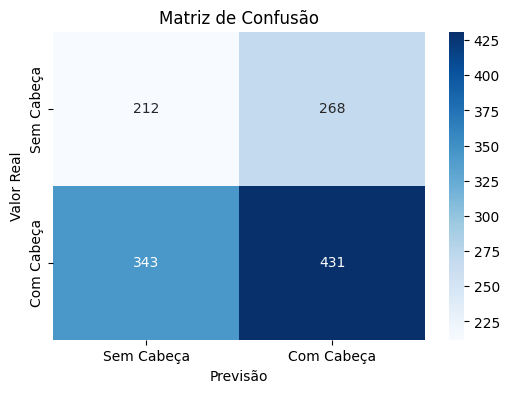

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Avaliar o modelo no conjunto de teste
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Acurácia no conjunto de teste: {test_acc:.4f}")

# Fazer previsões no conjunto de teste
y_pred = model.predict(test_generator)
y_pred_classes = np.round(y_pred).astype(int)  # Arredondar as previsões para 0 ou 1

# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_classes, target_names=['Sem Cabeça', 'Com Cabeça']))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sem Cabeça', 'Com Cabeça'], yticklabels=['Sem Cabeça', 'Com Cabeça'])
plt.title("Matriz de Confusão")
plt.ylabel('Valor Real')
plt.xlabel('Previsão')
plt.show()


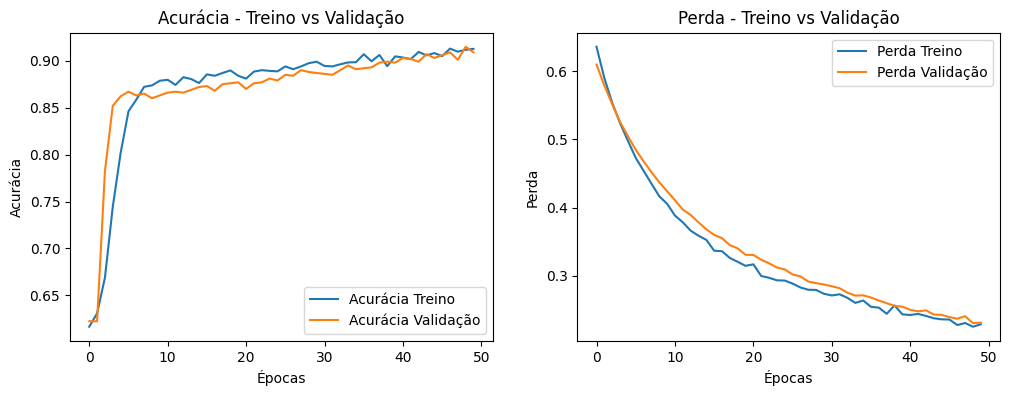

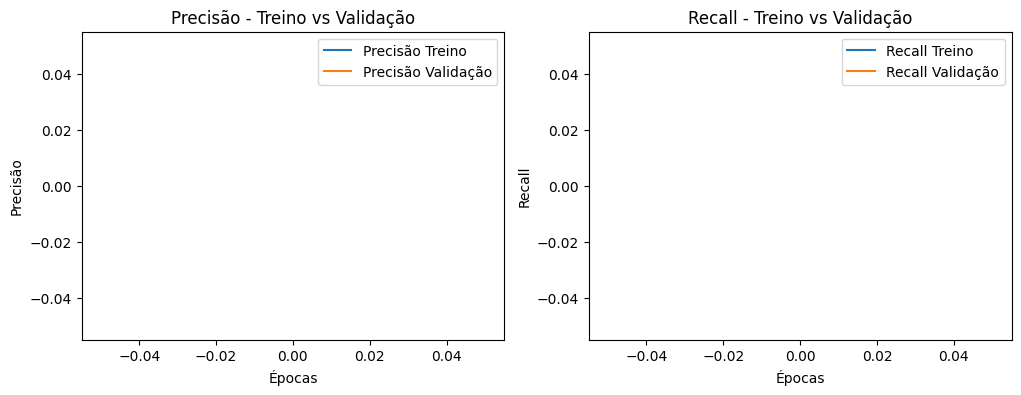

In [ ]:
import matplotlib.pyplot as plt

# Função para plotar a acurácia e perda do treino e validação
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plotar a Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.title('Acurácia - Treino vs Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Plotar a Perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda Treino')
    plt.plot(history.history['val_loss'], label='Perda Validação')
    plt.title('Perda - Treino vs Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

# Função para plotar as curvas de precisão e recall
def plot_precision_recall(history):
    plt.figure(figsize=(12, 4))

    # Plotar Precision (Precisão)
    plt.subplot(1, 2, 1)
    plt.plot(history.history.get('precision', []), label='Precisão Treino')
    plt.plot(history.history.get('val_precision', []), label='Precisão Validação')
    plt.title('Precisão - Treino vs Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.legend()

    # Plotar Recall
    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('recall', []), label='Recall Treino')
    plt.plot(history.history.get('val_recall', []), label='Recall Validação')
    plt.title('Recall - Treino vs Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()

    plt.show()

# Plotar os resultados do histórico do modelo
plot_history(history)
plot_precision_recall(history)
